In [30]:
from pyspark.sql import SparkSession
import numpy as np
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, DateType
from pyspark.sql.functions import col, when, sum as spark_sum
import zipfile
import os
from pyspark.sql.types import IntegerType, DateType
from pyspark.sql.functions import col, expr, count
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm


# Buscar una relación entre el Covid y las "Cormobilidades"

### Descomprimir el zip para no guardarlo en el git

Ese lo tengo guardado en una carpeta en el escritorio:
- Datos/Covid_limpio.csv


In [38]:
def descomprimir_zip(ruta_zip, carpeta_destino):
    # Crear carpeta si no existe
    os.makedirs(carpeta_destino, exist_ok=True)
    
    try:
        with zipfile.ZipFile(ruta_zip, 'r') as archivo_zip:
            # Extraer todo
            archivo_zip.extractall(carpeta_destino)
            
            # Mostrar información
            print(f"Archivo descomprimido: {ruta_zip}")
            return True
            
    except Exception as e:
        print(f"ERROR: {e}")
        return False


descomprimir_zip("archivo.zip", "Data/")

ERROR: [Errno 2] No such file or directory: 'archivo.zip'


False

### Creción de un schema

In [39]:
mi_esquema = StructType([
    StructField('FECHA_ACTUALIZACION', DateType(), True),
    StructField('ID_REGISTRO', StringType(), True),
    StructField('ORIGEN', StringType(), True),
    StructField('SECTOR', StringType(), True),
    StructField('ENTIDAD_UM', IntegerType(), True),
    StructField('SEXO', IntegerType(), True),
    StructField('ENTIDAD_NAC', IntegerType(), True),
    StructField('ENTIDAD_RES', IntegerType(), True),
    StructField('MUNICIPIO_RES', IntegerType(), True),
    StructField('FECHA_INGRESO', DateType(), True),
    StructField('FECHA_SINTOMAS', DateType(), True),
    StructField('FECHA_DEF', DateType(), True),
    StructField('INTUBADO', IntegerType(), True),
    StructField('NEUMONIA', IntegerType(), True),
    StructField('EDAD', IntegerType(), True),
    StructField('NACIONALIDAD', IntegerType(), True),
    StructField('EMBARAZO', IntegerType(), True),
    StructField('HABLA_LENGUA_INDIG', IntegerType(), True),
    StructField('INDIGENA', IntegerType(), True),
    StructField('DIABETES', IntegerType(), True),
    StructField('ASMA', IntegerType(), True),
    StructField('INMUSUPR', IntegerType(), True),
    StructField('HIPERTENSION', IntegerType(), True),
    StructField('OTRA_COM', IntegerType(), True),
    StructField('CARDIOVASCULAR', IntegerType(), True),
    StructField('OBESIDAD', IntegerType(), True),
    StructField('RENAL_CRONICA', IntegerType(), True),
    StructField('OTRO_CASO', IntegerType(), True),
    StructField('TOMA_MUESTRA_LAB', IntegerType(), True),
    StructField('RESULTADO_LAB', IntegerType(), True),
    StructField('TOMA_MUESTRA_ANTIGENO', IntegerType(), True),
    StructField('RESULTADO_ANTIGENO', IntegerType(), True),
    StructField('CLASIFICACION_FINAL', IntegerType(), True),
    StructField('MIGRANTE', IntegerType(), True),
    StructField('PAIS_NACIONALIDAD', StringType(), True),
    StructField('PAIS_ORIGEN', StringType(), True),
    StructField('UCI', IntegerType(), True)])


### Crear la spark session

In [2]:
spark = SparkSession.builder.appName('embarazos').getOrCreate()
ruta = 'Datos/Covid_limpio.csv'

df = spark.read.csv(
    ruta, 
    header = True,
    inferSchema=True,
    mode = 'DROPMALFORMED',
    multiLine = False,
    escape = "\"", 
)

df.show()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/12/17 00:45:08 WARN Utils: Your hostname, jair-Vivobook-ASUSLaptop-X1404ZA-F1404ZA, resolves to a loopback address: 127.0.1.1; using 192.168.0.12 instead (on interface wlo1)
25/12/17 00:45:08 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/17 00:45:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/12/17 00:46:07 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------------------+-----------+------+------+----------+----+-----------+-----------+-------------+-------------+-------------+--------------+----------+--------+--------+----+------------+--------+------------------+--------+--------+----+----+--------+------------+--------+--------------+--------+-------------+----------+---------+----------------+-------------+---------------------+------------------+-------------------+--------+-----------------+-----------+---+
|FECHA_ACTUALIZACION|ID_REGISTRO|ORIGEN|SECTOR|ENTIDAD_UM|SEXO|ENTIDAD_NAC|ENTIDAD_RES|MUNICIPIO_RES|TIPO_PACIENTE|FECHA_INGRESO|FECHA_SINTOMAS| FECHA_DEF|INTUBADO|NEUMONIA|EDAD|NACIONALIDAD|EMBARAZO|HABLA_LENGUA_INDIG|INDIGENA|DIABETES|EPOC|ASMA|INMUSUPR|HIPERTENSION|OTRA_COM|CARDIOVASCULAR|OBESIDAD|RENAL_CRONICA|TABAQUISMO|OTRO_CASO|TOMA_MUESTRA_LAB|RESULTADO_LAB|TOMA_MUESTRA_ANTIGENO|RESULTADO_ANTIGENO|CLASIFICACION_FINAL|MIGRANTE|PAIS_NACIONALIDAD|PAIS_ORIGEN|UCI|
+-------------------+-----------+------+------+-------

### Eliminar unas columnas de basura

In [3]:
fechas = [col for col in df.columns if 'FECHA_' in col and col != 'FECHA_DEF' and col != 'FECHA_INGRESO']
eliminar = ['ID_REGISTRO'] + fechas
df = df.drop(*eliminar)
df.show()

+------+------+----------+----+-----------+-----------+-------------+-------------+-------------+----------+--------+--------+----+------------+--------+------------------+--------+--------+----+----+--------+------------+--------+--------------+--------+-------------+----------+---------+----------------+-------------+---------------------+------------------+-------------------+--------+-----------------+-----------+---+
|ORIGEN|SECTOR|ENTIDAD_UM|SEXO|ENTIDAD_NAC|ENTIDAD_RES|MUNICIPIO_RES|TIPO_PACIENTE|FECHA_INGRESO| FECHA_DEF|INTUBADO|NEUMONIA|EDAD|NACIONALIDAD|EMBARAZO|HABLA_LENGUA_INDIG|INDIGENA|DIABETES|EPOC|ASMA|INMUSUPR|HIPERTENSION|OTRA_COM|CARDIOVASCULAR|OBESIDAD|RENAL_CRONICA|TABAQUISMO|OTRO_CASO|TOMA_MUESTRA_LAB|RESULTADO_LAB|TOMA_MUESTRA_ANTIGENO|RESULTADO_ANTIGENO|CLASIFICACION_FINAL|MIGRANTE|PAIS_NACIONALIDAD|PAIS_ORIGEN|UCI|
+------+------+----------+----+-----------+-----------+-------------+-------------+-------------+----------+--------+--------+----+------------+----

### Eliminarle los nulos al dataset

In [4]:
antes_null = df.count()
df = df.na.drop()
despues_null = df.count()
print(f'Datos nulos eliminados: {antes_null - despues_null}')

Datos nulos eliminados: 0


### Corrección ortográfica y de fechas

In [5]:
df = df.withColumn('PAIS_NACIONALIDAD',
                   when(col('PAIS_NACIONALIDAD') ==  'MÃ©xico', 'México'))

df = df.withColumn('FECHA_DEF',
                   when(col('FECHA_DEF') != '9999-99-99', col('FECHA_DEF')).otherwise(None))

df = df.withColumn('FECHA_DEF', 
                   expr("try_cast(FECHA_DEF as date)"))

df = df.filter((col('EDAD') >= 0) & (col('EDAD') <=110))

### Cambiarle los datos a numéricos para trabajarlos

In [6]:
numericas = [col for col in df.columns if col != 'PAIS_NACIONALIDAD' and col != 'FECHA_DEF' and col != 'FECHA_INGRESO']
for c in numericas:
    df = df.withColumn(c, col(c).cast(IntegerType()))

### Preparar columnas para un análisis estadístico

In [7]:
def crear_variables_cormobilidad(df):
    condiciones = ['DIABETES', 'HIPERTENSION', 'OBESIDAD', 'ASMA', 'EPOC', 'INMUSUPR', 'RENAL_CRONICA', 'TABAQUISMO']

    # Ponerles un contador
    df = df.withColumn("N_CORMOBILIDADES", 
                       when(col('DIABETES') == 1, 1).otherwise(0) +
                       when(col('HIPERTENSION') == 1, 1).otherwise(0) + 
                       when(col('OBESIDAD') == 1, 1).otherwise(0) + 
                       when(col('ASMA') == 1, 1).otherwise(0) + 
                       when(col('EPOC') == 1, 1).otherwise(0) + 
                       when(col('INMUSUPR') == 1, 1).otherwise(0) + 
                       when(col('RENAL_CRONICA') == 1, 1).otherwise(0) + 
                       when(col('TABAQUISMO') == 1, 1).otherwise(0))
    
    # Ponerles una categoría
    df = df.withColumn("CORM_CARDIOV",
                       when((col("HIPERTENSION") == 1) | (col("DIABETES") == 1) | (col("OBESIDAD") == 1), 1).otherwise(0)) 
    
    df = df.withColumn("CORM_RESP",
                       when((col("ASMA") == 1) | (col('EPOC') == 1), 1).otherwise(0))
    
    df = df.withColumn('COMR_INMUNOSUP',
                        when(col("INMUSUPR") == 1, 1).otherwise(0))
    
    df = df.withColumn('CORM_RENAL',
                        when(col('RENAL_CRONICA') == 1, 1).otherwise(0))
    
    df = df.withColumn('RIESGO',
                        when(col('N_CORMOBILIDADES') >= 3, 'EXTREMO')
                        .when(col('N_CORMOBILIDADES') == 2, 'ALTO')
                        .when(col('N_CORMOBILIDADES') == 1, 'MODERADO')
                        .when(col('N_CORMOBILIDADES') == 0, 'NORMAL'))
    return df

df = crear_variables_cormobilidad(df)
    

In [8]:
## Variable binaria para saber si son fallecidos
df = df.withColumn('SOBREVIVIO',
                   when(col('FECHA_DEF').isNotNull(), 0).otherwise(1))

## Variable para categorizar por grupos de edad
df = df.withColumn('CATEGORIA_EDAD',
                   when(col('EDAD') <= 2, 'BEBES')
                   .when(col('EDAD').between(3, 12), 'NINOS')
                   .when(col('EDAD').between(13, 19), 'JOVENES')
                   .when(col('EDAD').between(20, 50), 'ADULTOS')
                   .when(col('EDAD').between(51, 59), 'ADULTOS_MAYORES')
                   .otherwise('ANCIANOS'))

In [9]:
print('========== Dimensiones del dataset final ==========')
print(f'Filas   : {df.count()}')
print(f'Columnas: {len(df.columns)}')
df.show()

========== Dimensiones del dataset final ==========


Filas   : 17305951
Columnas: 45
+------+------+----------+----+-----------+-----------+-------------+-------------+-------------+---------+--------+--------+----+------------+--------+------------------+--------+--------+----+----+--------+------------+--------+--------------+--------+-------------+----------+---------+----------------+-------------+---------------------+------------------+-------------------+--------+-----------------+-----------+---+----------------+------------+---------+--------------+----------+--------+----------+---------------+
|ORIGEN|SECTOR|ENTIDAD_UM|SEXO|ENTIDAD_NAC|ENTIDAD_RES|MUNICIPIO_RES|TIPO_PACIENTE|FECHA_INGRESO|FECHA_DEF|INTUBADO|NEUMONIA|EDAD|NACIONALIDAD|EMBARAZO|HABLA_LENGUA_INDIG|INDIGENA|DIABETES|EPOC|ASMA|INMUSUPR|HIPERTENSION|OTRA_COM|CARDIOVASCULAR|OBESIDAD|RENAL_CRONICA|TABAQUISMO|OTRO_CASO|TOMA_MUESTRA_LAB|RESULTADO_LAB|TOMA_MUESTRA_ANTIGENO|RESULTADO_ANTIGENO|CLASIFICACION_FINAL|MIGRANTE|PAIS_NACIONALIDAD|PAIS_ORIGEN|UCI|N_CORMOBILIDADES|

### Bebés fumadores

Esta se va a dejar considerando que se trata de fumadores en la casa del bebé

In [10]:
bb_fuma = df.filter((col('EDAD') == 0) & (col('TABAQUISMO') == 1)).count()
print(f'N bebes que fuman: {bb_fuma}')

N bebes que fuman: 536


### Embarazos mal registrados

In [11]:
cond_bb_emb = (col('EDAD') == 0) & (col('EMBARAZO') == 1)
bb_emb = df.filter(cond_bb_emb).count()
df = df.filter(~cond_bb_emb)

print(f'Bebés embarazados: {bb_emb}')
print(f'Data Frame limpio: {df.count()}')

Bebés embarazados: 94


Data Frame limpio: 17305857


In [12]:
cond_may_emb = ((col('EDAD') >= 50) & (col('EMBARAZO') == 1)) 
old_emb = df.filter(cond_may_emb).count()
df = df.filter(~cond_may_emb)
print(f'Adultos mayores embarazados: {old_emb}')
print(f'Data Frame limpio: {df.count()}')

Adultos mayores embarazados: 654


Data Frame limpio: 17305203


### Cuántos sobrevivieron y cuántos no en total

In [13]:
si = df.filter(col('SOBREVIVIO') == 1).count()
no = df.filter(col('SOBREVIVIO') == 0).count()
total = df.count()
porcentaje_total = np.round((si/total)*100, 2)
print(f'Si sobrevivieron : {si}')
print(f'No sobrevivieron : {no}')
print(f'Total            : {total}')
print(f'Supervivencia    : {porcentaje_total}%')

Si sobrevivieron : 16881773
No sobrevivieron : 423430
Total            : 17305203
Supervivencia    : 97.55%


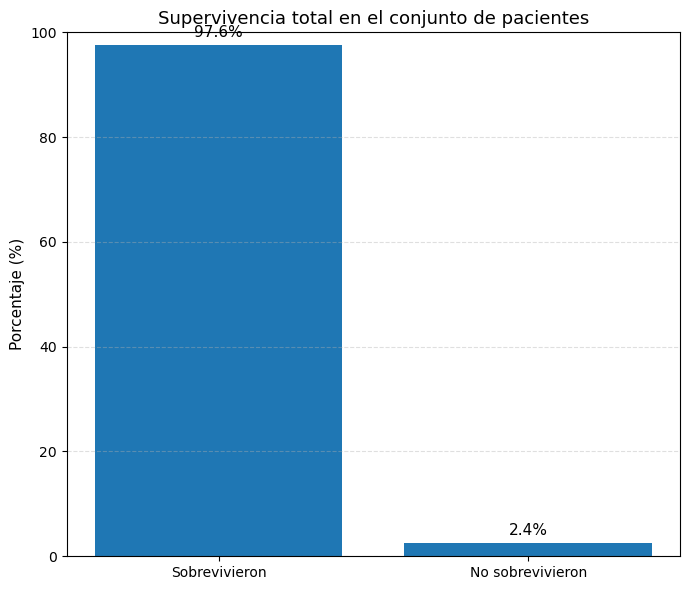

In [14]:
labels = ['Sobrevivieron', 'No sobrevivieron']
values = [si, no]
percentages = [
    (si / total) * 100,
    (no / total) * 100
]

x = np.arange(len(labels))

plt.figure(figsize=(7, 6))
bars = plt.bar(x, percentages)

plt.ylabel('Porcentaje (%)', fontsize=11)
plt.title('Supervivencia total en el conjunto de pacientes', fontsize=13)
plt.xticks(x, labels)
plt.ylim(0, 100)

# Etiquetas encima de las barras
for bar, pct in zip(bars, percentages):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 1,
        f'{pct:.1f}%',
        ha='center',
        va='bottom',
        fontsize=11
    )

plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()



### Cormobilidad por las edades

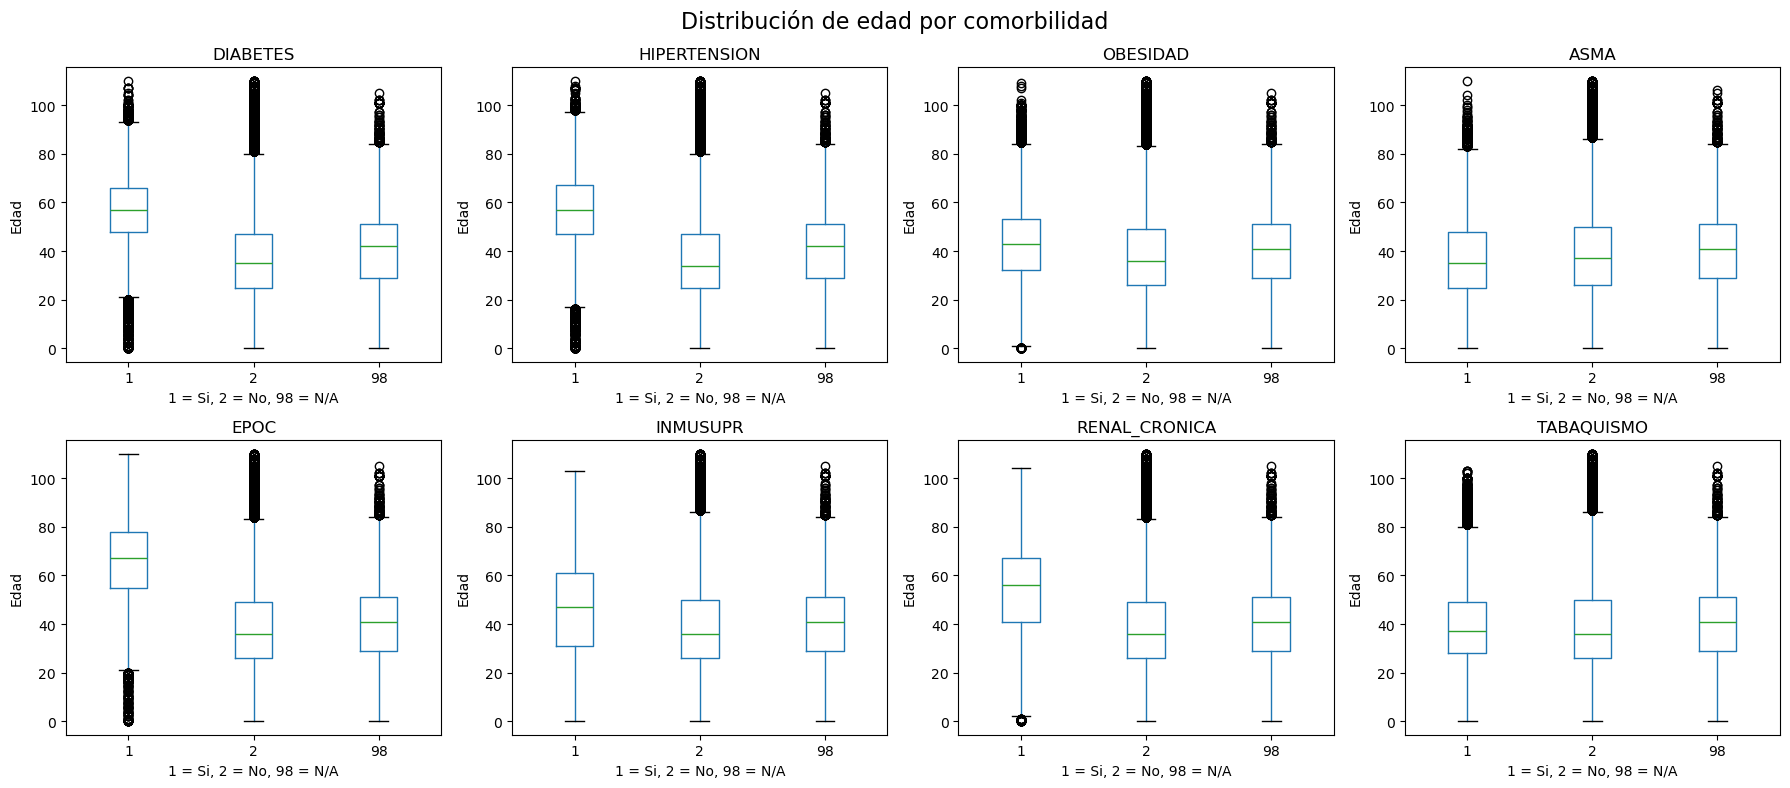

In [ ]:
df_box = df.select(
    'EDAD',
    'DIABETES',
    'HIPERTENSION',
    'OBESIDAD',
    'ASMA',
    'EPOC',
    'INMUSUPR',
    'RENAL_CRONICA',
    'TABAQUISMO'
)

df_box = df_box.sample(fraction=0.1, seed=42)
pdf = df_box.toPandas()

comorbilidades = [
    'DIABETES',
    'HIPERTENSION',
    'OBESIDAD',
    'ASMA',
    'EPOC',
    'INMUSUPR',
    'RENAL_CRONICA',
    'TABAQUISMO'
]

fig, axes = plt.subplots(2, 4, figsize=(18, 8))
axes = axes.flatten()

for ax, com in zip(axes, comorbilidades):
    pdf.boxplot(
        column='EDAD',
        by=com,
        ax=ax,
        grid=False,
        showfliers=True
    )
    ax.set_title(com)
    ax.set_xlabel('1 = Si, 2 = No, 98 = N/A')
    ax.set_ylabel('Edad')

plt.suptitle('Distribución de edad por comorbilidad', fontsize=16)
plt.tight_layout()
plt.show()


### Cuántos sobrevivieron y cuántos no de los que tenían una Cormobilidad y no la tenían

In [17]:
df_con_cormobibles = df.filter(col('N_CORMOBILIDADES') >= 1)
df_sin_cormobibles = df.filter(col('N_CORMOBILIDADES') == 0)

si_con = df_con_cormobibles.filter(col('SOBREVIVIO') == 1).count()
no_con = df_con_cormobibles.filter(col('SOBREVIVIO') == 0).count()
total_cormobibles = df_con_cormobibles.count()  
porcentaje_con = np.round((si_con/total_cormobibles)*100, 2)

si_sin = df_sin_cormobibles.filter(col('SOBREVIVIO') == 1).count()
no_sin = df_sin_cormobibles.filter(col('SOBREVIVIO') == 0).count()
total_normales = df_sin_cormobibles.count()  
porcentaje_sin = np.round((si_sin/total_normales)*100, 2)

print('===== Con Cormobilidad =====')
print(f'Si sobrevivieron        : {si_con}')
print(f'No sobrevivieron        : {no_con}')
print(f'Total con Cormobilidad  : {total_cormobibles}')
print(f'Porcentaje supervivencia: {porcentaje_con}')

print('===== Sin Cormobilidad =====')
print(f'Si sobrevivieron       : {si_sin}')
print(f'No sobrevivieron       : {no_sin}')
print(f'Total sin Cormobilidad : {total_normales}')
print(f'Porcentaje supervivencia: {porcentaje_sin}')


===== Con Cormobilidad =====
Si sobrevivieron        : 4181920
No sobrevivieron        : 286429
Total con Cormobilidad  : 4468349
Porcentaje supervivencia: 93.59
===== Sin Cormobilidad =====
Si sobrevivieron       : 12699853
No sobrevivieron       : 137001
Total sin Cormobilidad : 12836854
Porcentaje supervivencia: 98.93


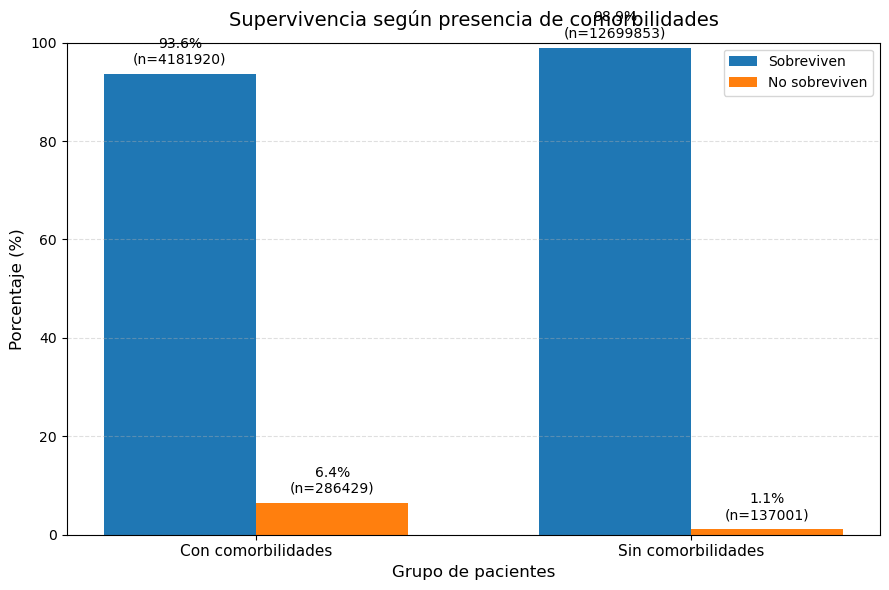

In [18]:
labels = ['Con comorbilidades', 'Sin comorbilidades']

# Porcentajes
sobreviven_pct = [
    (si_con / total_cormobibles) * 100,
    (si_sin / total_normales) * 100
]

no_sobreviven_pct = [
    (no_con / total_cormobibles) * 100,
    (no_sin / total_normales) * 100
]

# Conteos (para anotaciones)
sobreviven_cnt = [si_con, si_sin]
no_sobreviven_cnt = [no_con, no_sin]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(9, 6))

bars1 = plt.bar(x - width/2, sobreviven_pct, width, label='Sobreviven')
bars2 = plt.bar(x + width/2, no_sobreviven_pct, width, label='No sobreviven')

plt.ylabel('Porcentaje (%)', fontsize=12)
plt.xlabel('Grupo de pacientes', fontsize=12)
plt.title('Supervivencia según presencia de comorbilidades', fontsize=14, pad=12)
plt.xticks(x, labels, fontsize=11)
plt.ylim(0, 100)
plt.legend()

# Etiquetas encima de las barras (porcentaje + n)
for bars, counts in zip([bars1, bars2], [sobreviven_cnt, no_sobreviven_cnt]):
    for bar, cnt in zip(bars, counts):
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height + 1.5,
            f'{height:.1f}%\n(n={cnt})',
            ha='center',
            va='bottom',
            fontsize=10
        )

plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


### Cormobilidades por grupos de edad 

* Observar estatus de supervivencia por categorias de edad en general

In [19]:
df_estatusxcat = df.groupBy('CATEGORIA_EDAD', 'SOBREVIVIO').agg(count('SOBREVIVIO').alias('CONTEO_SUPERVIVENCIA'))
df_estatusxcat = df_estatusxcat.withColumn('ORDEN',
                                           when(col('CATEGORIA_EDAD') == 'NIÑOS', 1)
                                           .when(col('CATEGORIA_EDAD') == 'ADOLESCENTES', 2)
                                           .when(col('CATEGORIA_EDAD') == 'JOVENES', 3)
                                           .when(col('CATEGORIA_EDAD') == 'ADULTOS_JOVENES', 4)
                                           .when(col('CATEGORIA_EDAD') == 'ADULTOS', 5)
                                           .when(col('CATEGORIA_EDAD') == 'ADULTOS_MAYORES', 6)
                                           .when(col('CATEGORIA_EDAD') == 'ANCIANOS', 7))

print('========== Estatus de supervivencia por categorias de edad en general ==========')
df_estatusxcat.orderBy('ORDEN', 'SOBREVIVIO').drop('ORDEN').show()
                                                                                                                               

========== Estatus de supervivencia por categorias de edad en general ==========


+---------------+----------+--------------------+
| CATEGORIA_EDAD|SOBREVIVIO|CONTEO_SUPERVIVENCIA|
+---------------+----------+--------------------+
|          NINOS|         0|                1089|
|          BEBES|         0|                2060|
|          BEBES|         1|              189369|
|          NINOS|         1|              674025|
|        JOVENES|         0|                1453|
|        JOVENES|         1|              998758|
|        ADULTOS|         0|               80302|
|        ADULTOS|         1|            11282257|
|ADULTOS_MAYORES|         0|               75483|
|ADULTOS_MAYORES|         1|             1971708|
|       ANCIANOS|         0|              263043|
|       ANCIANOS|         1|             1765656|
+---------------+----------+--------------------+



### Cuántos tienen Cormobilidades?

In [20]:
si_tienen = df.filter(col('N_CORMOBILIDADES') > 0).count()
no_tienen = df.filter(col('N_CORMOBILIDADES') == 0).count()
porcentaje_cormo = np.round((si_tienen / total) * 100, 2)

print('===== Cuántos tienen o no tienen Cormobilidades? =====')
print(f'Si tienen: {si_tienen}')
print(f'No tienen: {no_tienen}')

print(f'{porcentaje_cormo}% de los pacientes tienen al menos una cormobilidad')

===== Cuántos tienen o no tienen Cormobilidades? =====
Si tienen: 4468349
No tienen: 12836854
25.82% de los pacientes tienen al menos una cormobilidad


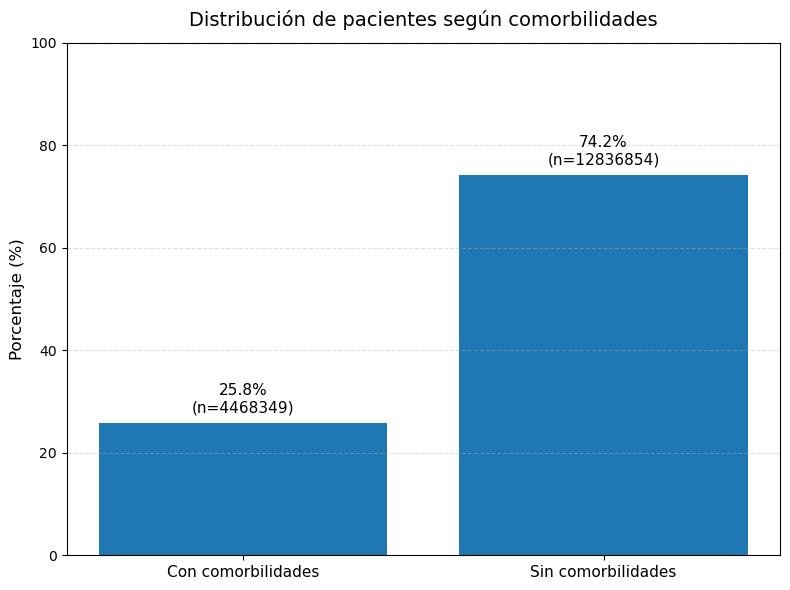

In [21]:
labels = ['Con comorbilidades', 'Sin comorbilidades']
counts = [si_tienen, no_tienen]
percentages = [
    (si_tienen / total) * 100,
    (no_tienen / total) * 100
]

x = np.arange(len(labels))

plt.figure(figsize=(8, 6))
bars = plt.bar(x, percentages)

plt.ylabel('Porcentaje (%)', fontsize=12)
plt.title('Distribución de pacientes según comorbilidades', fontsize=14, pad=12)
plt.xticks(x, labels, fontsize=11)
plt.ylim(0, 100)

# Etiquetas: porcentaje + n
for bar, pct, cnt in zip(bars, percentages, counts):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 1.5,
        f'{pct:.1f}%\n(n={cnt})',
        ha='center',
        va='bottom',
        fontsize=11
    )

plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


### Supervivencia
* Sin Cormobilidades
* Con Cormobilidades

In [23]:
# Sin Cormobilidades
def_sin_corm = df.filter((df['N_CORMOBILIDADES'] == 0) & (df['SOBREVIVIO'] == 0)).count()
sob_sin_corm = df.filter((df['N_CORMOBILIDADES'] == 0) & (df['SOBREVIVIO'] == 1)).count()

# Con Cormobilidades
def_con_corm = df.filter((df['N_CORMOBILIDADES'] >= 1) & (df['SOBREVIVIO'] == 0)).count()
sob_con_corm = df.filter((df['N_CORMOBILIDADES'] >= 1) & (df['SOBREVIVIO'] == 1)).count()


print('===== Supervivencia sin Cormobilidades =====')
print(f'Número de defunciones   : {def_sin_corm}')
print(f'Número de sobrevivientes: {sob_sin_corm}')
print(f'Tasa de supervivencia   : {np.round((sob_sin_corm / (sob_sin_corm + def_sin_corm)* 100), 2)}%')

print('\n===== Supervivencia con Cormobilidades =====')
print(f'Número de defunciones   : {def_con_corm}')
print(f'Número de sobrevivientes: {sob_con_corm}')
print(f'Tasa de supervivencia   : {np.round((sob_con_corm / (sob_con_corm + def_con_corm)* 100), 2)}%')

===== Supervivencia sin Cormobilidades =====
Número de defunciones   : 137001
Número de sobrevivientes: 12699853
Tasa de supervivencia   : 98.93%

===== Supervivencia con Cormobilidades =====
Número de defunciones   : 286429
Número de sobrevivientes: 4181920
Tasa de supervivencia   : 93.59%


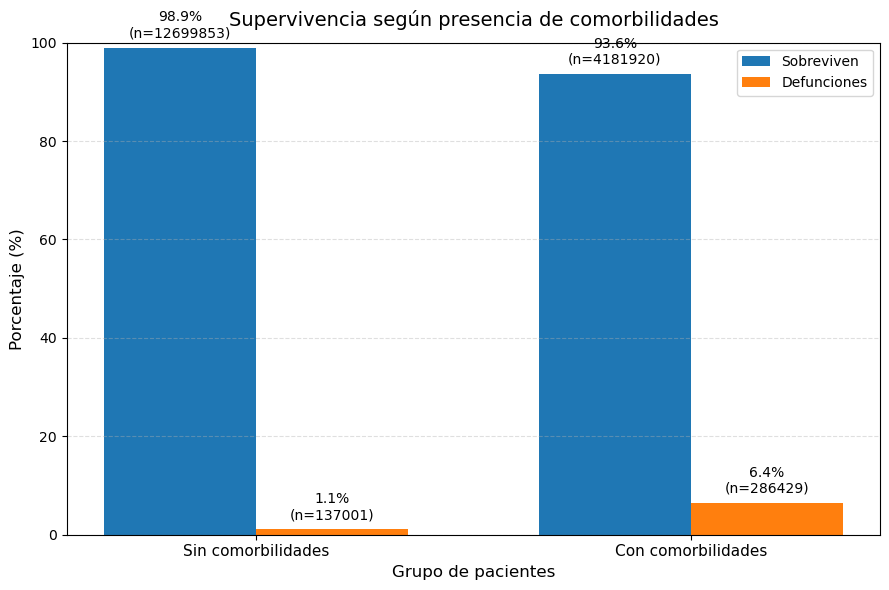

In [106]:
labels = ['Sin comorbilidades', 'Con comorbilidades']

# Conteos
sobreviven = [sob_sin_corm, sob_con_corm]
defunciones = [def_sin_corm, def_con_corm]

# Totales por grupo
totales = [
    sob_sin_corm + def_sin_corm,
    sob_con_corm + def_con_corm
]

# Porcentajes
sobreviven_pct = [
    (sob_sin_corm / totales[0]) * 100,
    (sob_con_corm / totales[1]) * 100
]

defunciones_pct = [
    (def_sin_corm / totales[0]) * 100,
    (def_con_corm / totales[1]) * 100
]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(9, 6))

bars1 = plt.bar(x - width/2, sobreviven_pct, width, label='Sobreviven')
bars2 = plt.bar(x + width/2, defunciones_pct, width, label='Defunciones')

plt.ylabel('Porcentaje (%)', fontsize=12)
plt.xlabel('Grupo de pacientes', fontsize=12)
plt.title('Supervivencia según presencia de comorbilidades', fontsize=14, pad=12)
plt.xticks(x, labels, fontsize=11)
plt.ylim(0, 100)
plt.legend()

# Etiquetas: porcentaje + n
for bars, counts in zip([bars1, bars2], [sobreviven, defunciones]):
    for bar, cnt in zip(bars, counts):
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height + 1.5,
            f'{height:.1f}%\n(n={cnt})',
            ha='center',
            va='bottom',
            fontsize=10
        )

plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


### Supervivencia según el riesgo

In [24]:
df_estatusxriesgo = df.groupBy('RIESGO', 'SOBREVIVIO').agg(count('SOBREVIVIO').alias('CONTEO_SUPERVIVENCIA_POR_RIESGO'))
df_estatusxriesgo = df_estatusxriesgo.withColumn('ORDEN',
                                           when(col('RIESGO') == 'NORMAL', 1)
                                           .when(col('RIESGO') == 'MODERADO', 2)
                                           .when(col('RIESGO') == 'ALTO', 3)
                                           .when(col('RIESGO') == 'EXTREMO', 4))

print('========== Estatus de supervivencia por categorias de RIESGO ==========')
df_estatusxriesgo.orderBy('ORDEN', 'SOBREVIVIO').drop('ORDEN').show()

========== Estatus de supervivencia por categorias de RIESGO ==========


+--------+----------+-------------------------------+
|  RIESGO|SOBREVIVIO|CONTEO_SUPERVIVENCIA_POR_RIESGO|
+--------+----------+-------------------------------+
|  NORMAL|         0|                         137001|
|  NORMAL|         1|                       12699853|
|MODERADO|         0|                         122803|
|MODERADO|         1|                        2901682|
|    ALTO|         0|                         101859|
|    ALTO|         1|                         966016|
| EXTREMO|         0|                          61767|
| EXTREMO|         1|                         314222|
+--------+----------+-------------------------------+



### Cuántos de los intubados tenían cormobilidades

In [25]:
cond_intubado_cormo   = ((col('N_CORMOBILIDADES') >= 1) & (col('INTUBADO') == 1))
cond_intubado_nocormo = ((col('N_CORMOBILIDADES') == 0) & (col('INTUBADO') == 1))

df_intubado_cormo   = df.filter(cond_intubado_cormo)
df_intubado_nocormo = df.filter(cond_intubado_nocormo)

n_intubado_cormo   = df_intubado_cormo.count()
n_intubado_nocormo = df_intubado_nocormo.count()

cond_sobrevive   = (col('SOBREVIVIO') == 1)
cond_nosobrevive = (col('SOBREVIVIO') == 0)

n_intubado_cormo_sobrevive   = df_intubado_cormo.filter(cond_sobrevive).count()
n_intubado_cormo_nosobrevive = df_intubado_cormo.filter(cond_nosobrevive).count()

n_intubado_nocormo_sobrevive   = df_intubado_nocormo.filter(cond_sobrevive).count()
n_intubado_nocormo_nosobrevive = df_intubado_nocormo.filter(cond_nosobrevive).count()


print('===== INTUBADOS CON CORMOBILIDADES =====')
print(f'Cantidad: {n_intubado_cormo}')
print(f'Si Sobreviven: {n_intubado_cormo_sobrevive}')
print(f'No Sobreviven: {n_intubado_cormo_nosobrevive}')
print(f'% Si Sobreviven: {np.round((n_intubado_cormo_sobrevive/n_intubado_cormo)*100, 2)}%')
print(f'% No Sobreviven: {np.round((n_intubado_cormo_nosobrevive/n_intubado_cormo)*100, 2)}%')

print('\n===== INTUBADOS SIN CORMOBILIDADES =====')
print(f'Cantidad: {n_intubado_nocormo}')
print(f'Si Sobreviven: {n_intubado_nocormo_sobrevive}')
print(f'No Sobreviven: {n_intubado_nocormo_nosobrevive}')
print(f'% Si Sobreviven: {np.round((n_intubado_nocormo_sobrevive/n_intubado_nocormo)*100, 2)}%')
print(f'% No Sobreviven: {np.round((n_intubado_nocormo_nosobrevive/n_intubado_nocormo)*100, 2)}%')

===== INTUBADOS CON CORMOBILIDADES =====
Cantidad: 76256
Si Sobreviven: 15279
No Sobreviven: 60977
% Si Sobreviven: 20.04%
% No Sobreviven: 79.96%

===== INTUBADOS SIN CORMOBILIDADES =====
Cantidad: 40493
Si Sobreviven: 13024
No Sobreviven: 27469
% Si Sobreviven: 32.16%
% No Sobreviven: 67.84%


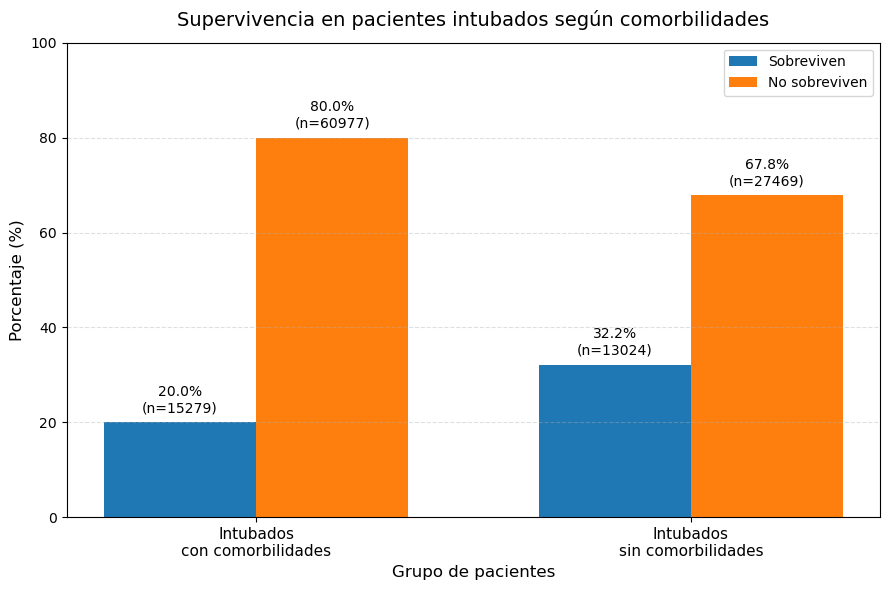

In [26]:
labels = ['Intubados\ncon comorbilidades', 'Intubados\nsin comorbilidades']

# Conteos
sobreviven = [
    n_intubado_cormo_sobrevive,
    n_intubado_nocormo_sobrevive
]

no_sobreviven = [
    n_intubado_cormo_nosobrevive,
    n_intubado_nocormo_nosobrevive
]

# Totales por grupo
totales = [
    n_intubado_cormo,
    n_intubado_nocormo
]

# Porcentajes
sobreviven_pct = [
    (sobreviven[0] / totales[0]) * 100,
    (sobreviven[1] / totales[1]) * 100
]

no_sobreviven_pct = [
    (no_sobreviven[0] / totales[0]) * 100,
    (no_sobreviven[1] / totales[1]) * 100
]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(9, 6))

bars1 = plt.bar(x - width/2, sobreviven_pct, width, label='Sobreviven')
bars2 = plt.bar(x + width/2, no_sobreviven_pct, width, label='No sobreviven')

plt.ylabel('Porcentaje (%)', fontsize=12)
plt.xlabel('Grupo de pacientes', fontsize=12)
plt.title('Supervivencia en pacientes intubados según comorbilidades', fontsize=14, pad=12)
plt.xticks(x, labels, fontsize=11)
plt.ylim(0, 100)
plt.legend()

# Etiquetas: porcentaje + n
for bars, counts in zip([bars1, bars2], [sobreviven, no_sobreviven]):
    for bar, cnt in zip(bars, counts):
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height + 1.5,
            f'{height:.1f}%\n(n={cnt})',
            ha='center',
            va='bottom',
            fontsize=10
        )

plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


### Edad de pacientes vs suprevivencia de los intubados con cormobilidades

<Figure size 800x600 with 0 Axes>

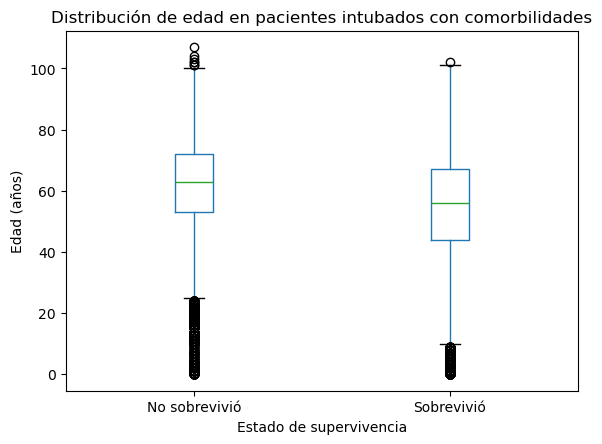

In [ ]:
df_box = df_intubado_cormo.select('Edad', 'SOBREVIVIO')
pdf = df_box.toPandas()

plt.figure(figsize=(8, 6))

pdf.boxplot(
    column='Edad',
    by='SOBREVIVIO',
    grid=False,
    showfliers=True
)

plt.title('Distribución de edad en pacientes intubados con comorbilidades')
plt.suptitle('')
plt.xlabel('Estado de supervivencia')
plt.ylabel('Edad (años)')
plt.xticks([1, 2], ['No sobrevivió', 'Sobrevivió'])

plt.show()



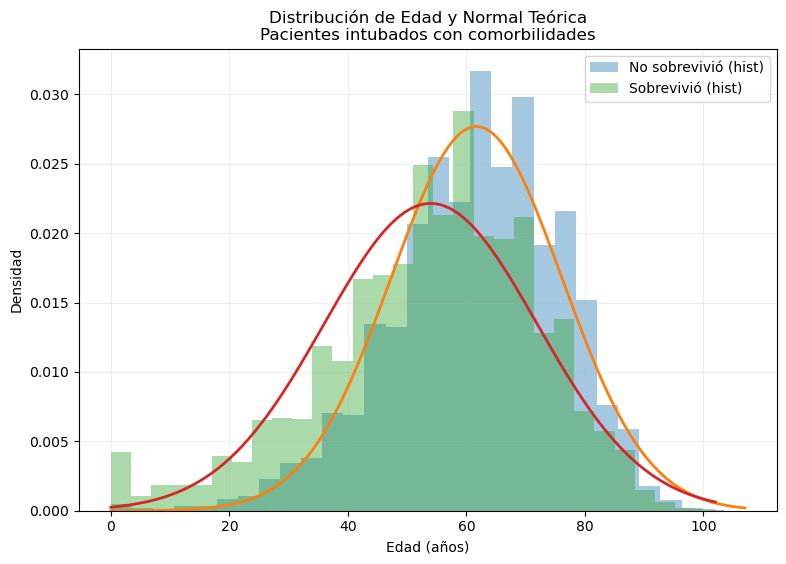

In [31]:
plt.figure(figsize=(9, 6))

for status, label in [(0, 'No sobrevivió'), (1, 'Sobrevivió')]:
    data = pdf.loc[pdf['SOBREVIVIO'] == status, 'Edad'].dropna()
    
    # Parámetros de la normal
    mu, sigma = data.mean(), data.std()
    
    # Histograma normalizado
    plt.hist(
        data,
        bins=30,
        density=True,
        alpha=0.4,
        label=f'{label} (hist)'
    )
    
    # Curva normal teórica
    x = np.linspace(data.min(), data.max(), 300)
    plt.plot(x, norm.pdf(x, mu, sigma), linewidth=2)

plt.title('Distribución de Edad y Normal Teórica\nPacientes intubados con comorbilidades')
plt.xlabel('Edad (años)')
plt.ylabel('Densidad')
plt.legend()
plt.grid(alpha=0.2)
plt.show()
